In [108]:
# Generic
import os, json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [109]:
# Modelling
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [110]:
print(os.getcwd())
parent_path = './'
sample_submissions = pd.read_csv(parent_path + 'gender_submission.csv')
sample_submissions.head()

/home/karthicp/Desktop/titanic


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [111]:
data = pd.read_csv(parent_path + 'train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [112]:
def dummy_var(transformed, var):
    for sv in set(transformed[var]):
        transformed[var + '_' + sv] = [1 if v == sv else 0 for v in transformed[var]]
    transformed.drop(var, axis=1, inplace=True)

def transform(df):
    transformed = df.copy()

    transformed['Title'] = [i.split(',')[-1].strip().split(' ')[0] for i in transformed['Name']]
    transformed['Cabin_Level'] = [i[0] if type(i) == str else 'N' for i in transformed['Cabin']]
    transformed['Embarked'] = [i if type(i) == str else 'N' for i in transformed['Embarked']]
    transformed['Age'].fillna(np.mean(transformed['Age']), inplace=True)

    transformed.drop('Name', axis=1, inplace=True)
    transformed.drop('Cabin', axis=1, inplace=True)
    transformed.drop('Ticket', axis=1, inplace=True)

    dummy_var(transformed, 'Title')
    dummy_var(transformed, 'Sex')
    dummy_var(transformed, 'Cabin_Level')
    dummy_var(transformed, 'Embarked')

    return transformed

transformed = transform(data)
transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 39 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      891 non-null    int64  
 1   Survived         891 non-null    int64  
 2   Pclass           891 non-null    int64  
 3   Age              891 non-null    float64
 4   SibSp            891 non-null    int64  
 5   Parch            891 non-null    int64  
 6   Fare             891 non-null    float64
 7   Title_Capt.      891 non-null    int64  
 8   Title_Mr.        891 non-null    int64  
 9   Title_Miss.      891 non-null    int64  
 10  Title_Dr.        891 non-null    int64  
 11  Title_Mme.       891 non-null    int64  
 12  Title_Ms.        891 non-null    int64  
 13  Title_Mlle.      891 non-null    int64  
 14  Title_Don.       891 non-null    int64  
 15  Title_Sir.       891 non-null    int64  
 16  Title_Mrs.       891 non-null    int64  
 17  Title_Major.    

In [113]:
n = transformed.shape[0]
n_survived = sum(transformed['Survived'])
pct_survived = n_survived*100/n
print(pct_survived)

labels = ['Survived']
variables = [col for col in transformed.columns if col not in labels]
print(labels)

38.38383838383838
['Survived']


In [114]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
     transformed[variables], transformed['Survived'], test_size=0.2, 
     random_state=0, shuffle=True, stratify=transformed[labels]
)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((712, 38), (712,), (179, 38), (179,))

In [115]:
sum(y_test)*100/179, sum(y_train)*100/712

(38.547486033519554, 38.342696629213485)

In [154]:
param_grid = {}
param_grid['svc'] = {
    'C': [i for i in np.linspace(0.1,30,20)], 
    'degree': [2,3,4],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}
param_grid['rfc'] = {
    'bootstrap': [True,False],
    'max_depth': [int(i) for i in np.linspace(2,40,5)],
    'max_features': ["auto"],
    'criterion': ['gini','entropy'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [2, 4, 6, 8, 10],
    'n_estimators': [int(i) for i in np.linspace(10, 200, 10)]
}
param_grid['xgb'] = {
    'learning_rate': [0.05, 0.5, 5, 50], #so called `eta` value
    'max_depth': [4, 10, 20, 40],
    'min_child_weight': [3, 5, 9],
    'silent': [1, 2, 4, 9],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.7],
    'n_estimators': [5, 10, 50, 100], #number of trees, change it to 1000 for better results
}
param_grid['lgbm'] = {
    'num_leaves': [2, 3, 5, 10],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [10, 30, 50, 100, 300],
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1],
    'max_depth': [int(i*2) for i in np.logspace(0,1.7,10)]
}
param_grid['svc']

{'C': [0.1,
  1.6736842105263159,
  3.2473684210526317,
  4.821052631578947,
  6.394736842105263,
  7.968421052631578,
  9.542105263157895,
  11.11578947368421,
  12.689473684210526,
  14.263157894736842,
  15.836842105263157,
  17.410526315789475,
  18.984210526315792,
  20.55789473684211,
  22.13157894736842,
  23.705263157894738,
  25.278947368421054,
  26.85263157894737,
  28.426315789473687,
  30.0],
 'degree': [2, 3, 4],
 'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}

In [163]:
class Classifier:
    def __init__(self, model, X_train, y_train, X_test, y_test, param_grid, grid_search=True, randomized_search=False, 
                 scoring='roc_auc', verbose=4, n_iter=100):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        switch_model = { 
            "svc": SVC(), 
            "rfc": RandomForestClassifier(), 
            "xgb": XGBClassifier(), 
            "lgbm": LGBMClassifier(),
        } 
        self.model = switch_model.get(model, "")
        if type(self.model) == str:
            raise Exception("Invalid model")
        self.param_grid = param_grid[model]
        if grid_search:
            self.model = GridSearchCV(self.model, self.param_grid, scoring=scoring, n_jobs=-1, verbose=verbose, cv=5)
        elif randomized_search:
            self.model = RandomizedSearchCV(self.model, self.param_grid, scoring=scoring, n_jobs=-1, verbose=verbose, 
                                          cv=5, n_iter=100)
    
    def fit_predict(self):
        self.model.fit(self.X_train, self.y_train)
        self.y_pred = self.model.predict(self.X_test)
        self.y_pred_train = self.model.predict(self.X_train)

clf = {'svc':None,'rfc':None,'xgb':None,'lgbm':None}
for model in clf:
    print("Fitting model:",model)
    clf[model] = Classifier(model, X_train, y_train, X_test, y_test, param_grid, scoring='accuracy')
    clf[model].fit_predict()

Fitting model: svc
Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 372 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 593 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 862 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 1181 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 25.6min finished


Fitting model: rfc
Fitting 5 folds for each of 3000 candidates, totalling 15000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 382 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 724 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 1166 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 2342 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 3076 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 3910 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done 4840 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5870 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 6996 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 8222 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 9544 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 10966 tasks      

Fitting model: xgb
Fitting 5 folds for each of 1536 candidates, totalling 7680 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 2612 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 7388 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 7680 out of 7680 | elapsed:   19.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Fitting model: lgbm
Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2236 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 4972 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 8508 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 11981 out of 12000 | elapsed:   21.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 12000 out of 12000 | elapsed:   21.8s finished


In [164]:
print(clf['rfc'].model.best_estimator_)
print(clf['xgb'].model.best_estimator_)
print(clf['lgbm'].model.best_estimator_)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=11, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic

Model: svc


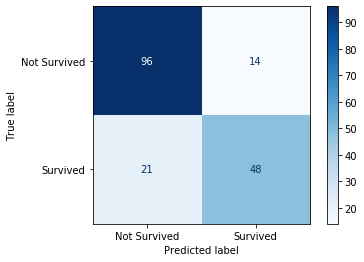

Model: rfc


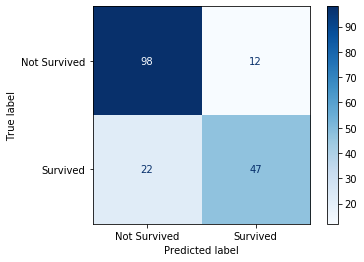

Model: xgb


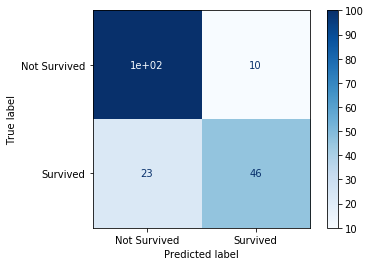

Model: lgbm


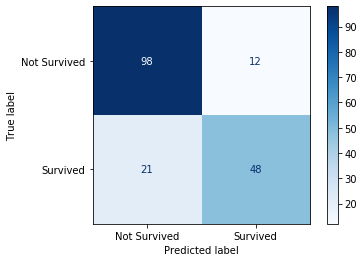

In [165]:
from sklearn.metrics import plot_confusion_matrix
for model in clf.keys():
    print("Model:",model)
    disp = plot_confusion_matrix(clf[model].model.best_estimator_, clf[model].X_test, clf[model].y_test, display_labels=['Not Survived', 'Survived'],cmap=plt.cm.Blues)
    plt.show()

In [166]:
for model in clf:
    print('Model:',model, '; Accuracy score:', accuracy_score(clf[model].y_test, clf[model].y_pred))

Model: svc ; Accuracy score: 0.8044692737430168
Model: rfc ; Accuracy score: 0.8100558659217877
Model: xgb ; Accuracy score: 0.8156424581005587
Model: lgbm ; Accuracy score: 0.8156424581005587


In [167]:
for model in clf:
    print('Model:',model, '; Accuracy score:', accuracy_score(clf[model].y_train, clf[model].y_pred_train))

Model: svc ; Accuracy score: 0.8328651685393258
Model: rfc ; Accuracy score: 0.8707865168539326
Model: xgb ; Accuracy score: 0.9213483146067416
Model: lgbm ; Accuracy score: 0.9044943820224719


In [141]:
test = pd.read_csv('test.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [142]:
test_transformed = transform(test)
test_transformed['Fare'] = test_transformed['Fare'].fillna(0)
extra_columns = [col for col in transformed.columns if col not in test_transformed.columns]
print(extra_columns)
for col in extra_columns:
    if col != 'Survived':
        test_transformed[col] = [0]*test_transformed.shape[0]
redundant_columns  = [col for col in test_transformed.columns if col not in transformed.columns]
print(redundant_columns)
for col in redundant_columns:
    test_transformed.drop(col, axis=1, inplace=True)
test_transformed.info()

['Survived', 'Title_Capt.', 'Title_Mme.', 'Title_Mlle.', 'Title_Don.', 'Title_Sir.', 'Title_Major.', 'Title_Lady.', 'Title_the', 'Title_Jonkheer.', 'Cabin_Level_T', 'Embarked_N']
['Title_Dona.']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 38 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      418 non-null    int64  
 1   Pclass           418 non-null    int64  
 2   Age              418 non-null    float64
 3   SibSp            418 non-null    int64  
 4   Parch            418 non-null    int64  
 5   Fare             418 non-null    float64
 6   Title_Mr.        418 non-null    int64  
 7   Title_Miss.      418 non-null    int64  
 8   Title_Dr.        418 non-null    int64  
 9   Title_Ms.        418 non-null    int64  
 10  Title_Col.       418 non-null    int64  
 11  Title_Mrs.       418 non-null    int64  
 12  Title_Master.    418 non-null    int64  
 13  Title

In [146]:
y = clf['xgb'].clf.predict(test_transformed[clf[model].X_test.columns])
y

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [147]:
pd.DataFrame({'PassengerId':test_transformed['PassengerId'], 'Survived':y}).to_csv('predict.csv', index=False)